<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# A tutorial for using River Bed Dynamics and Overland Flow Components in a coupled way

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This notebook illustrates the process of running the river bed dynamics component coupled to the 2D deAlmeida overland flow component in an initially flat bed river that receives excess sediment supply. Then, it shows how the bed slope is adjusted continously in time and space until it reaches a new bed elevation equilibrium.

First, import what we'll need:

In [1]:
import numpy as np
import copy
from matplotlib import pyplot as plt
from landlab.components import OverlandFlow, RiverBedDynamics
from landlab.io import read_esri_ascii
from landlab import imshow_grid
from landlab.grid.mappers import map_mean_of_link_nodes_to_link

Now, we define some numerical simulation conditions, time control settings, filenames to access the grain size distribution and the digital elevation model (DEM), and boundary conditions

In [2]:
bedElevation = 'bedElevationDEM.asc' # ASCII raster DEM containing the bed surface elevation
gsd = np.loadtxt('bed_gsd.txt')      # Check inside the txt file for more information on the file format
t = 0                                # Elapsed time (sec)
max_dt = 5                           # time step in sec
simulation_max_time = 5*86400        # Maximum simulation time (sec) - To compare to analytical solution set as 240*86400

n = 0.03874                          # Manning's n
upstream_sediment_supply = -0.0087   # bedload rate at inlet in m3/s
link_inlet = np.array((221,222))     # Link Id in which sediment supply and discharge enters
node_inlet = np.array((129,130))     # Nodes Id in Water depth is specified
fixed_nodes_Id = np.array((1,2,5,6)) # Node ID for fixed Nodes

Now we create fields and instantiate the OverlandFlow component

In [3]:
OverlandFlow.input_var_names # Gives the list of all required fields

('surface_water__depth', 'topographic__elevation')

Therefore, we need to create the surface_water__depth and topographic__elevation fields. Also, we will create a copy of the topographic elevation to use it as comparison point at the end of the run.

In [4]:
(rmg, z) = read_esri_ascii(bedElevation, name='topographic__elevation') # Creates the topographic__elevation field
rmg.add_zeros('surface_water__depth', at = 'node')                      # Creates the surface_water__depth and fills it with zeros
rmg['node']['topographic__elevation_original'] = rmg['node']['topographic__elevation'] # A copy of the original topographic__elevation

It would be benefitial to take a look at the geometry at this point

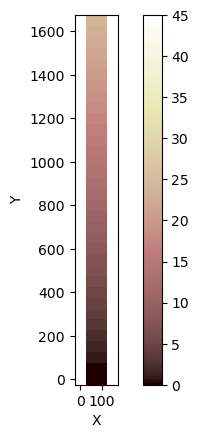

In [5]:
imshow_grid(rmg, "topographic__elevation", vmin = 0, vmax = 45)

Now we instantiate the Overland flow component

In [6]:
of = OverlandFlow(rmg, dt_max=max_dt,h_init=0.001,mannings_n=n,use_user_defined_time_step=True)


And now we create fields and instantiate the river bed dynamics component, to check the required we do:

In [7]:
RiverBedDynamics.input_var_names

('bed_surface__grain_size_distribution_location',
 'surface_water__depth',
 'surface_water__velocity',
 'surface_water__velocity_previous_time',
 'topographic__elevation')

We have to create all these fields. Notice that 'topographic__elevation' was already created. the field 'surface_water__depth' was created but it was defined on nodes and here we need it at links.

In [8]:
rmg['node']['bed_surface__grain_size_distribution_location'] = np.zeros_like(z) # There is only one site
rmg.add_zeros('surface_water__velocity', at = 'node')
rmg.add_zeros('surface_water__velocity_previous_time', at = 'node')
rmg['link']['surface_water__depth'] = map_mean_of_link_nodes_to_link(rmg,'surface_water__depth')
rmg['link']['surface_water__velocity'] = map_mean_of_link_nodes_to_link(rmg,'surface_water__velocity')
rmg['link']['surface_water__velocity_previous_time'] = map_mean_of_link_nodes_to_link(rmg,'surface_water__velocity_previous_time')

Instantiate the river bed dynamics component

In [9]:
rbd = RiverBedDynamics(rmg , gsd = gsd, variable_critical_shear_stress = True, outlet_boundary_condition='fixedValue')

We set boundaries as closed boundaries, the outlet is set to an open boundary

In [10]:
rmg.set_watershed_boundary_condition_outlet_id([1,2], z, 45.)

A little explanation of what we did for the watershed boundary condition. Our DEM represents a long watershed with a given slope in the central region. The outlet is in the south boundary, which according to landlab grid convention is defined as nodes 1 and 2 (that is why we have ...outlet_id([1,2]..., then z contains the bed surface elevation created when we did:
(rmg, z) = read_esri_ascii(bedElevation, name='topographic__elevation'), and 45 tells the component that if that value exist in the DEM it is an invalid value. Most commonly it is used as -9999.

Now we defined some properties of fixed nodes (nodes with fixed bed elevation), define the flow discharge and depth at the inlet node, and the sediment supply at the node that we previously defined.


In [11]:
fixed_nodes = np.zeros_like(z)   # fixed_nodes defines as 1 if a node is fixed or 0 if it can vary in elevation
fixed_nodes[fixed_nodes_Id] = 1
rmg['node']['bed_surface__elevation_fixed'] = fixed_nodes # Assigns fixed locations to landlab grid 

rmg["link"]["surface_water__discharge"][link_inlet] = -1    # Flow discharge in m3/s/m
rmg["node"]["surface_water__depth"][node_inlet] = 0.45      # Flow depth in nodes in m
rmg["link"]["surface_water__depth"][link_inlet] = 0.45      # Flow depth in links in m
rmg['link']['sediment_transport__sediment_supply_imposed'][link_inlet] = upstream_sediment_supply




Here we define some ghost cells. In this tutorial we are analyzing a 1500 m long reach, but the DEM contains data up to 1650 m. Outside 1500 m, where is the point in which the sediment supply is defined, the bed elevation is assumed to vary according to a gradient preserving condition, a boundary condition that allows the water to flow without problems. We will called these nodes calculated_nodes_Id

In [12]:
calculated_nodes_Id = np.arange(128,136)
number_columns = rmg.number_of_node_columns
number_rows_calculated_nodes = int(calculated_nodes_Id.shape[0]/number_columns)
calculated_nodes_Id = np.reshape(calculated_nodes_Id,(number_rows_calculated_nodes,number_columns))

Now we're going to run the loop that drives the components:

In [13]:
progress0 = 0 # The simulation may take a long time to run, so we added a progress report
while t < simulation_max_time:

    # Boundary conditions of discharge and flow depth
    rmg["link"]["surface_water__discharge"][link_inlet] = -1    # Flow discharge in m3/s/m
    rmg["node"]["surface_water__depth"][node_inlet] = 0.45      # Flow depth in nodes in m
    rmg["link"]["surface_water__depth"][link_inlet] = 0.45      # Flow depth in links in m
    
    # Velocity at previous time
    rmg['link']['surface_water__velocity_previous_time'] = of._q / of._h_links
    
    of.overland_flow()  # Runs overland flow for one time step
    
    # Velocity at current time
    rmg['link']['surface_water__velocity'] = of._q / of._h_links
    
    rbd.run_one_step()  # Runs riverBedDynamics for one time step
        
    # Gradient preserving at upstream ghost cells
    dsNodesId = np.array(calculated_nodes_Id[0,1]-np.arange(1,3)*number_columns)
    z = rmg['node']['topographic__elevation'] # Updated topographic elevation
    bedSlope = (z[dsNodesId[0]] - z[dsNodesId[1]]) / rmg.dx
    
    for i in np.arange(0,calculated_nodes_Id.shape[0]):
        rmg['node']['topographic__elevation'][calculated_nodes_Id[i,1:number_columns-1]] = z[calculated_nodes_Id[i,1:number_columns-1] - 2*number_columns] + 2 * rmg.dx * bedSlope
    
    t += of.dt
    progress = int( (t/simulation_max_time) * 100 )
    if progress > progress0 + 1:
        print('\r' + f'Progress: [{progress}%]', end='')
        progress0 = progress
        

Progress: [100%]

Let's take a look at the new topography and the water depth field

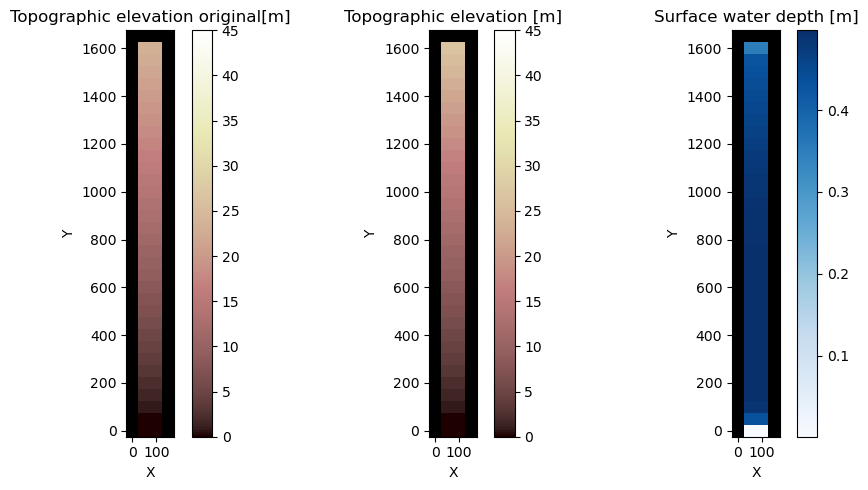

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

plt.sca(axs[0])  
imshow_grid(rmg, "topographic__elevation_original", vmin = 0, vmax = 45)
plt.title('Topographic elevation original[m]')

plt.sca(axs[1])  
imshow_grid(rmg, "topographic__elevation", vmin = 0, vmax = 45)
plt.title('Topographic elevation [m]')  # set a title

plt.sca(axs[2])
imshow_grid(rmg, "surface_water__depth", cmap="Blues")
plt.title('Surface water depth [m]')

plt.tight_layout()
plt.show()

After five days, noticeable changes occur in the bed, with deposition observed predominantly in the upper part. Stable bed conditions are typically achieved after roughly 160 days. Therefore, if the goal is to observe the maximum possible change under the set experimental conditions, you should set: simulation_max_time = 16*86400

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>